### Gaussian copula with only location matrix ie: a single kernel

In [1]:
%matplotlib inline
from scipy.optimize import dual_annealing
import numpy as np
import scipy.stats as scs
from matplotlib import pyplot as plt
from sklearn.gaussian_process.kernels import Matern
from collections import Counter
import plotly.graph_objects as go
from collections import Counter
import numpy as np

In [2]:
#makes the banana density region shift with most sigmas!

#first class is with sigma allowed to change - not used yet
class norm_cop_loconly():

    def __init__(self,L=np.array([[0,1,1],[1,0,1],[1,1,0]])):
        '''
        L is location matrix: n x n
        '''
        self.N=L.shape[0]
        self.L=L

    def sim(self,theta,draws=3,as_x=True):
        '''
        Returns: [ [m [draws of length n] for day t+1],..., [m [draws of length n] for day t+T_(depending on prediction matricies X_all)] ]
        So to get the samples from day t+1: sim[1-1]
        To get k th draw from samples at day t+T: sim[T-1][k-1]
        To get u for 3rd location of kth drw for day T: sim[T-1][k-1][3-1]'''
        cov_mat=Matern(length_scale=theta[1],nu=theta[2]).__call__(self.L) *np.power(theta[0],2)  
        if as_x==True:
            return [scs.multivariate_normal.rvs(mean=np.zeros(self.N),cov=cov_mat) for i in range(draws) ] 
        if as_x==False:
            Us=[np.zeros(self.N) for i in range(draws)] 
            for i in range(draws):
                Us[i]=[scs.multivariate_normal.cdf(y,mean=0,cov=cov_mat[idx,idx]) for idx,y in enumerate(scs.multivariate_normal.rvs(mean=np.zeros(self.N),cov=cov_mat))]
            return Us

    
    def nll(self,theta,data):
        '''
        theta: [sigma,p0,v0,p1,v1] vector of parameters for the Matern Kernel
        data: [[u1,..,un],...,[...]] one set of (n: one for each location) us for each day 1 to T (T is the number of predictor matricies).
        '''
        nll=0
        cov_mat=Matern(length_scale=theta[1],nu=theta[2]).__call__(self.L) *np.power(theta[0],2) 

        for day in range(len(data)):
            #nll for the copula density: joint and marginals
            nll+=scs.multivariate_normal.logpdf([scs.norm.ppf(obs,loc=0,scale=cov_mat[idx,idx]) for idx,obs in enumerate(data[day])],mean=np.zeros(self.N),cov=cov_mat) 
            nll+=-np.sum([scs.norm.logpdf(obs,loc=0,scale=cov_mat[idx,idx]) for idx,obs in enumerate(data[day])])
        return -nll


# This class is with sigma fixed at 1 - This is what is used for the rest of this notebook
class norm_cop_loconly():

    def __init__(self,L=np.array([[0,1,1],[1,0,1],[1,1,0]])):
        '''
        L is location matrix: n x n
        '''
        self.N=L.shape[0]
        self.L=L

    def sim(self,theta,draws=3,as_x=True):
        '''
        Returns: [ [m [draws of length n] for day t+1],..., [m [draws of length n] for day t+T_(depending on prediction matricies X_all)] ]
        So to get the samples from day t+1: sim[1-1]
        To get k th draw from samples at day t+T: sim[T-1][k-1]
        To get u for 3rd location of kth drw for day T: sim[T-1][k-1][3-1]'''
        cov_mat=Matern(length_scale=theta[0],nu=theta[1]).__call__(self.L) *np.power(1,2)  
        #sigma should be in theta ##############################

        if as_x==True:
            return [scs.multivariate_normal.rvs(mean=np.zeros(self.N),cov=cov_mat) for i in range(draws) ] 
        if as_x==False:
            Us=[np.zeros(self.N) for i in range(draws)] 
            for i in range(draws):
                Us[i]=[scs.multivariate_normal.cdf(y,mean=0,cov=cov_mat[idx,idx]) for idx,y in enumerate(scs.multivariate_normal.rvs(mean=np.zeros(self.N),cov=cov_mat))]
            return Us

    
    def nll(self,theta,data):
        '''
        theta: [sigma,p0,v0,p1,v1] vector of parameters for the Matern Kernel
        data: [[u1,..,un],...,[...]] one set of (n: one for each location) us for each day 1 to T (T is the number of predictor matricies).
        '''
        nll=0
        cov_mat=Matern(length_scale=theta[0],nu=theta[1]).__call__(self.L) *np.power(1,2) 
        #sigma should be in theta ##############################

        for day in range(len(data)):
            #nll for the copula density: joint and marginals
            nll+=scs.multivariate_normal.logpdf([scs.norm.ppf(obs,loc=0,scale=cov_mat[idx,idx]) for idx,obs in enumerate(data[day])],mean=np.zeros(self.N),cov=cov_mat) 
            nll+=-np.sum([scs.norm.logpdf(obs,loc=0,scale=cov_mat[idx,idx]) for idx,obs in enumerate(data[day])])
        return -nll
        

### Getting marginals and rain values 

In [3]:
### load gamma
model_version = 0
target_distribution = "gamma_hurdle"
base_nn = "HLSTM_tdscale" #(Keep this fixed)

# Run this to get the prediction data in a variable named city_data
# Getting data
sys.path.append('../')
import glms
import pickle
import torch

path_ = f"Checkpoints/uk_rain_DGLM_{base_nn}_{target_distribution}/lightning_logs/version_{model_version}/"
ckpt_path = glms.NeuralDGLM.get_ckpt_path(os.path.join(path_,"checkpoints"))

scaler_features, scaler_target = glms.NeuralDGLM.load_scalers(path_)
model = glms.NeuralDGLM.load_from_checkpoint(ckpt_path, save_hparams=False, scaler_features=scaler_features, scaler_target=scaler_target)
model.freeze()
model.eval()

test_output = pickle.load( open(os.path.join(path_,"test_output.pkl"),"rb") )
cities=['London', 'Cardiff', 'Glasgow', 'Manchester', 'Birmingham', 'Liverpool', 'Edinburgh', 'Dublin', 
'Preston', 'Truro', 'Bangor', 'Plymouth', 'Salford']

gamma_allcities=[]

for i,location in enumerate(cities):
    city_data = test_output[location] 
    gamma_allcities.append([i,location,city_data['pred_mu'],city_data['pred_disp'],city_data['pred_p'],city_data['target_rain_value'],city_data['date']])
#[0:i,1:location,2:['pred_mu'],3:['pred_disp'],4:['pred_p'],5:['target_rain_value'],6:date


c:\Users\david\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:329: UserWarning: Trying to unpickle estimator StandardScaler from version 0.23.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\david\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:329: UserWarning: Trying to unpickle estimator MinMaxScaler from version 0.23.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\david\Desktop\GNN UK daily\Notebooks\..\neural_nets.py:273: UserWarning: torch.range is deprecated and will be removed in a future release because its beha

### Distance matrix

In [4]:
#loc_dist matrix
#distance matrix
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
from geopy.geocoders import Nominatim
from tqdm import tqdm
from datetime import datetime
import itertools
from itertools import permutations
from scipy.spatial import distance_matrix


#[1, 3, 4, 7, 10, 13, 16, 17, 19, 23, 30] 11 locations used
x11_lat=[]
y11_lon=[]
geolocator = Nominatim(user_agent = "Google")
country ="United Kingdom"
cities = ["London",
"Cardiff",
"Glasgow",
"Manchester",
"Birmingham",
"Liverpool",
"Edinburgh",
"Dublin",
"Preston",
"Truro",
"Bangor",
"Plymouth",
"Salford"]


m = Basemap(projection='mill',
            resolution='c',llcrnrlat = 49.205456,
            llcrnrlon = -10.055147,
            urcrnrlat = 60.002848,
            urcrnrlon = 2.431562)
            
for index,city in tqdm(enumerate([cities[city] for city in range(13)])):
    x11_lat.append(geolocator.geocode(city+','+ country).longitude)
    y11_lon.append(geolocator.geocode(city+','+ country).latitude)

id_loc=[[x11_lat[k],y11_lon[k]] for k in range(13)]

loc_dist_mat=distance_matrix(id_loc,id_loc,2)
loc_dist_mat.shape

13it [00:12,  1.00it/s]


(13, 13)

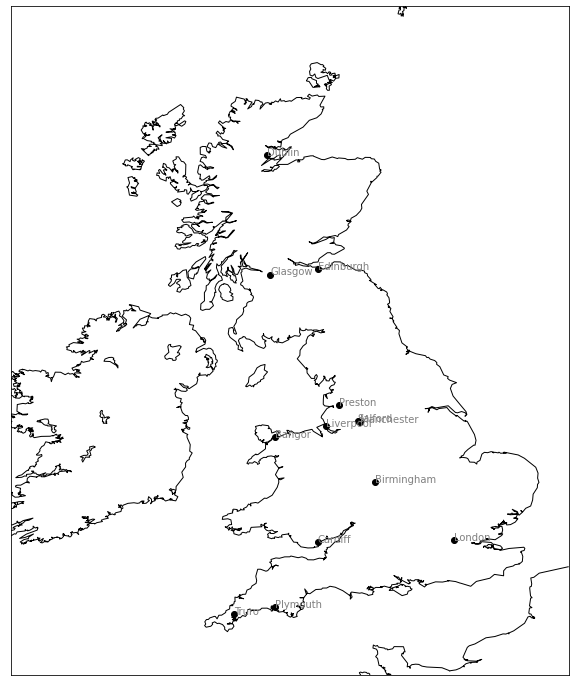

In [5]:
#locations on map
fig = plt.gcf()
fig.set_size_inches(10, 20)
dpi=300
m = Basemap(projection='mill',
            resolution='i',llcrnrlat = 49.205456,
            llcrnrlon = -10.055147,
            urcrnrlat = 60.002848,
            urcrnrlon = 2.431562)
m.drawcoastlines()

for k in range(13):
    x,y=m(id_loc[k][0],id_loc[k][1])
    plt.scatter(x,y,color='black')
    plt.text(x,y,cities[k],color='grey')
plt.show()


### Getting Us for the 11 locations at the overlapping dates

In [6]:
#us for 11 locs
#index_for_overlapdays : [[days at loc 1], [days loc2], [days loc3]]
g_us11_pre=[[] for place in range(13)]
for idx,i in enumerate(range(13)):
    g_us11_pre[idx]=[ (1-gamma_allcities[i][4][day]-np.power(0.1,2))+((gamma_allcities[i][4][day]+np.power(0.1,2))*scs.gamma(scale=1/(gamma_allcities[i][3][day]*gamma_allcities[i][2][day]),a=1/gamma_allcities[i][3][day]).cdf(gamma_allcities[i][5][day]) )for day in range(1977) ]
#Now g_us_pre is a list of F(rain) for loc [[0],[16],[19]]
#the following gets us to 402 days of [u1,u2,u3] ie [[u1,u2,u3]_day1, [u1,u2,u3]_day2, ... , [u1,u2,u3]_day106]
g_11us=[]
for i in range(len(g_us11_pre[0])):
    g_11us.append([g_us11_pre[k][i] for k in range(13)])
g_11us_arr=np.array(g_11us)
g_11us_arr[g_11us_arr==1]=0.99
g_11us_arr=abs(g_11us_arr)
norm_cop_loconly(L=loc_dist_mat).nll([5,5],g_11us_arr)#now just fit the copla to this data of us with the 11loc matrix

19624608.341118142

### Fitting the copula for all locations

In [139]:
dual_annealing(norm_cop_loconly(L=loc_dist_mat).nll,bounds=[[1e+13,1e+14],[2.1e-03,5.1e-03]],args=[g_11us_arr],maxiter=15)
#norm_cop_loconly(L=loc_dist_mat).nll(result['x'],g_11us_arr)

     fun: 45937.19774070704
 message: ['Maximum number of iteration reached']
    nfev: 79
    nhev: 0
     nit: 15
    njev: 6
  status: 0
 success: True
       x: array([4.95639157e+13, 3.62785696e-03])

In [ ]:
#estimating params for copula - no need to do again - use any of the [rho, mu] below.

#random subsapmles used to estimate
#best so far 45936.11399873846, array([1.99955786e+13, 3.75838189e-03
iter=0
while True:
    spawn=round(np.random.uniform()*1977)
    result=dual_annealing(norm_cop_loconly(L=loc_dist_mat).nll,bounds=[[1.5e+13,7.3e+13],[1.1e-03,5.1e-03]],args=[g_11us_arr[round(spawn*0.8):spawn]],maxiter=10)
    print([norm_cop_loconly(L=loc_dist_mat).nll(result['x'],g_11us_arr),result['x']])
    iter+=+1
    print(iter)
       

### Density region for copula parameters

In [7]:
#plot of ll - prepare grid 

x_val11=np.linspace(1.99955786e+13 -(1e+10),1.99955786e+13 +(1e+10), 4)
y_val11=np.linspace((3.75838189e-03 )-0.001,(3.75838189e-03)+0.001 , 5)
X,Y =np.meshgrid(x_val11,y_val11)
Z=np.zeros(X.shape)
for i in range(Z.shape[0]):
    for j in tqdm(range(Z.shape[1])):
        Z[i,j]=-norm_cop_loconly(L=loc_dist_mat).nll([X[i,j],Y[i,j]],g_11us_arr)
    

100%|██████████| 4/4 [00:19<00:00,  4.86s/it]


In [135]:
norm_cop_loconly(L=loc_dist_mat).nll([1.00000031e+11, 4.90397460e-03],g_11us_arr)

45975.41581730501

In [144]:
Z

array([[-46499.14647461, -46499.1090431 , -46499.0716256 ,
        -46499.03422209],
       [-46057.16136936, -46057.14313575, -46057.12490977,
        -46057.10669144],
       [-45936.1118325 , -45936.11327634, -45936.1147213 ,
        -45936.11616738],
       [-46059.93357732, -46059.95516042, -46059.97673797,
        -46059.99830997],
       [-46378.42506464, -46378.46730999, -46378.50954297,
        -46378.55176357]])

C:\Users\david\AppData\Local\Temp\ipykernel_23212\844840737.py:2: UserWarning: The following kwargs were not used by contour: 'color'
  plt.contourf(X,Y,Z,1000,color='viridis',)


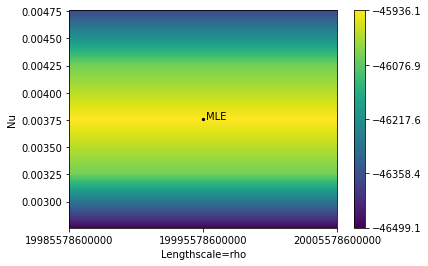

In [25]:
#draw it
plt.contourf(X,Y,Z,1000,color='viridis',)
plt.plot(figsize=(13,15))
plt.xlabel('Lengthscale=rho')
ticks = np.linspace(Z.min(), Z.max(), 5, endpoint=True)
cb = plt.colorbar(ticks=ticks)
plt.xticks([round(i) for i in np.linspace(X.min(),X.max(),3)],[round(i) for i in np.linspace(X.min(),X.max(),3)])
plt.ylabel('Nu')
plt.scatter(1.99955786e+13, 3.75838189e-03,s=5,color='black')
plt.text(1.99955786e+13+0.2e+9, 3.75838189e-03,'MLE')
plt.show() 

In [107]:
#prepare grid elsewhere
from tqdm import tqdm
param_pdf11=[]
x_val11=np.linspace(0.1,10.1, 20)
y_val11=np.linspace(0.1,5.1 , 20)
X,Y =np.meshgrid(x_val11,y_val11)
Z=np.zeros(X.shape)
for i in tqdm(range(Z.shape[0])):
    for j in range(Z.shape[1]):
        Z[i,j]=-norm_cop_loconly(L=loc_distmatrix11loc).nll([X[i,j],Y[i,j]],g_11us_fit)
    

100%|██████████| 20/20 [01:08<00:00,  3.44s/it]


C:\Users\david\AppData\Local\Temp\ipykernel_10492\3552411867.py:2: UserWarning: The following kwargs were not used by contour: 'color'
  plt.contourf(X,Y,Z,35,color='viridis',)


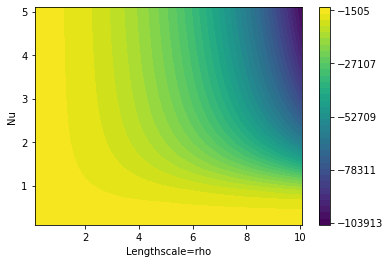

In [113]:
#draw elsewhere
plt.contourf(X,Y,Z,35,color='viridis',)
plt.xlabel('Lengthscale=rho')
ticks = np.linspace(Z.min(), Z.max(), 5, endpoint=True)
cb = plt.colorbar(ticks=ticks)
plt.ylabel('Nu')
plt.show() 

### Simulating from the copula and getting pseudo rainfall realisations

In [100]:
# now we can simulate us from the copula - plug in [rho, mu] -1000 draws/2.30minutes - no real difference above 1000 draws
from tqdm import tqdm 
fitted_11sim=norm_cop_loconly(L=loc_dist_mat).sim([1.99955786e+13, 3.75838189e-03],draws=1000,as_x=False)
sim_rain11_1000=[ [[]for k in range(13)] for i in range(25)]
#F inverse for gamma
def g_Finv(day_id,loc_id,u):
    if 1-gamma_allcities[loc_id][4][day_id]>u: #if 1-p>u, invcdf is 0 rain
        return 0
    else: # invcdf( (u-1+p) /p)
        return scs.gamma(scale=gamma_allcities[loc_id][3][day_id]*gamma_allcities[loc_id][2][day_id],a=1/gamma_allcities[loc_id][3][day_id]).ppf((u-1+gamma_allcities[loc_id][4][day_id])/gamma_allcities[loc_id][4][day_id])
        
# list with samples for each day for each location
for day in tqdm(range(25)):
    for sim_vec in fitted_11sim: #loop over the m=1000 samples for 11 locs: [loc1,loc2,loc3,...,loc11] 
        for loc_idx,loc_id in enumerate(range(13)):
            sim_rain11_1000[day][loc_idx].append(g_Finv(day_id=day+1977, loc_id=loc_id, u=sim_vec[loc_idx] ))

100%|██████████| 25/25 [01:16<00:00,  3.05s/it]


In [39]:
gamma_allcities[0][1]

'London'

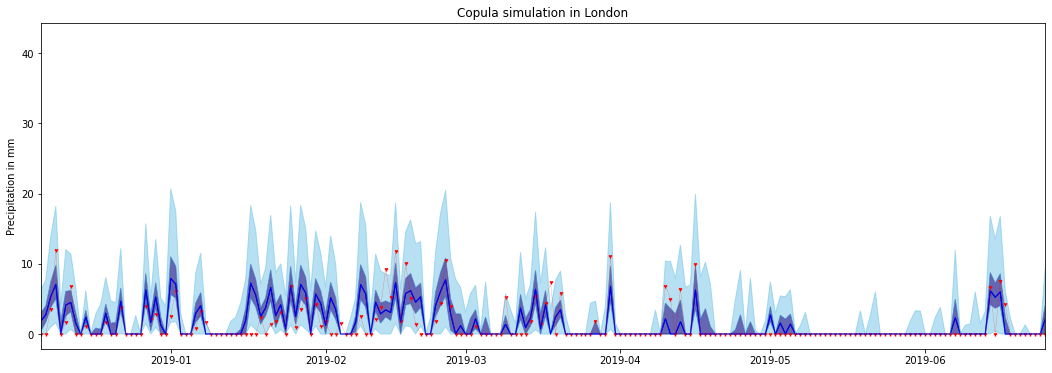

In [47]:
# all  locations in full
dpi=300
for idx,id in enumerate([0]):
    q_05fitted=[ sorted(sim_rain11_1000[i][idx])[49] for i in range(2002)]
    q_32fitted=[ sorted(sim_rain11_1000[i][idx])[319] for i in range(2002)]
    q_50fitted=[ sorted(sim_rain11_1000[i][idx])[499] for i in range(2002)]
    q_68fitted=[ sorted(sim_rain11_1000[i][idx])[679] for i in range(2002)]
    q_95fitted=[ sorted(sim_rain11_1000[i][idx])[949] for i in range(2002)]
    plt.figure(figsize=(18, 6))
    plt.plot(test_output['London']['date'],q_05fitted,color='skyblue',linewidth=0.6,alpha=0.3)
    plt.plot(test_output['London']['date'],q_32fitted,color='navy',linewidth=0.6,alpha=0.3)
    plt.plot(test_output['London']['date'],q_50fitted,color='blue',linewidth=1,alpha=1)
    plt.plot(test_output['London']['date'],q_68fitted,color='navy',linewidth=0.6,alpha=0.3)
    plt.plot(test_output['London']['date'],q_95fitted,color='skyblue',linewidth=0.6,alpha=0.3)
    plt.fill_between(test_output['London']['date'], q_50fitted, q_68fitted, where=([q_50fitted[k] < q_68fitted[k] for k in range(2002)]), color='navy', alpha=0.6,interpolate=True)
    plt.fill_between(test_output['London']['date'], q_50fitted, q_32fitted, where=([q_50fitted[k] > q_32fitted[k] for k in range(2002)]), color='navy', alpha=0.6,interpolate=True)
    plt.fill_between(test_output['London']['date'], q_95fitted, q_68fitted, where=([q_95fitted[k] > q_68fitted[k] for k in range(2002)]), color='skyblue', alpha=0.6,interpolate=True)
    plt.fill_between(test_output['London']['date'], q_05fitted, q_32fitted, where=([q_05fitted[k] < q_32fitted[k] for k in range(2002)]), color='skyblue', alpha=0.6,interpolate=True)
    plt.scatter(test_output['London']['date'],gamma_allcities[id][5],color='r',marker='1',s=16)
    plt.plot(test_output['London']['date'],gamma_allcities[id][5],color='r',alpha=0.5,linewidth=0.3)
    plt.title('Copula simulation in '+str(gamma_allcities[id][1]))
    plt.ylabel('Precipitation in mm')
    plt.xlim([test_output['London']['date'][1800],test_output['London']['date'][2001]])

    plt.show()


### Heatmap for true rain

In [87]:
### prepare map
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
from geopy.geocoders import Nominatim
from tqdm import tqdm
from datetime import datetime

#[1, 3, 4, 7, 10, 13, 16, 17, 19, 23, 30] 11 locations used
x11_lat=[]
y11_lon=[]
            
for index,city in enumerate([cities[city] for city in range(13)]):
    x11_lat.append(m(id_loc[index][0],1)[0])
    y11_lon.append(m(1,id_loc[index][1])[1])

#plt.tricontour(x11_lat,y11_lon,[gamma_allcities[k][5][1] for k in [1, 3, 4, 7, 10, 13, 16, 17, 19, 23, 30]])
from scipy.interpolate import griddata
xi = np.linspace(min(x11_lat), max(x11_lat), 50)
yi = np.linspace(min(y11_lon), max(y11_lon), 50)

'''median_sim=[]
for idx,id in enumerate(range(13)):
    median_sim.append([ sorted(sim_rain11_1000[i][idx])[499] for i in range(106)])
'''


'median_sim=[]\nfor idx,id in enumerate(range(13)):\n    median_sim.append([ sorted(sim_rain11_1000[i][idx])[499] for i in range(106)])\n'

In [82]:
from pandas import to_datetime
np.datetime64(gamma_allcities[0][6][1],Y)

TypeError: Invalid object for specifying NumPy datetime metadata

25it [00:09,  2.57it/s]


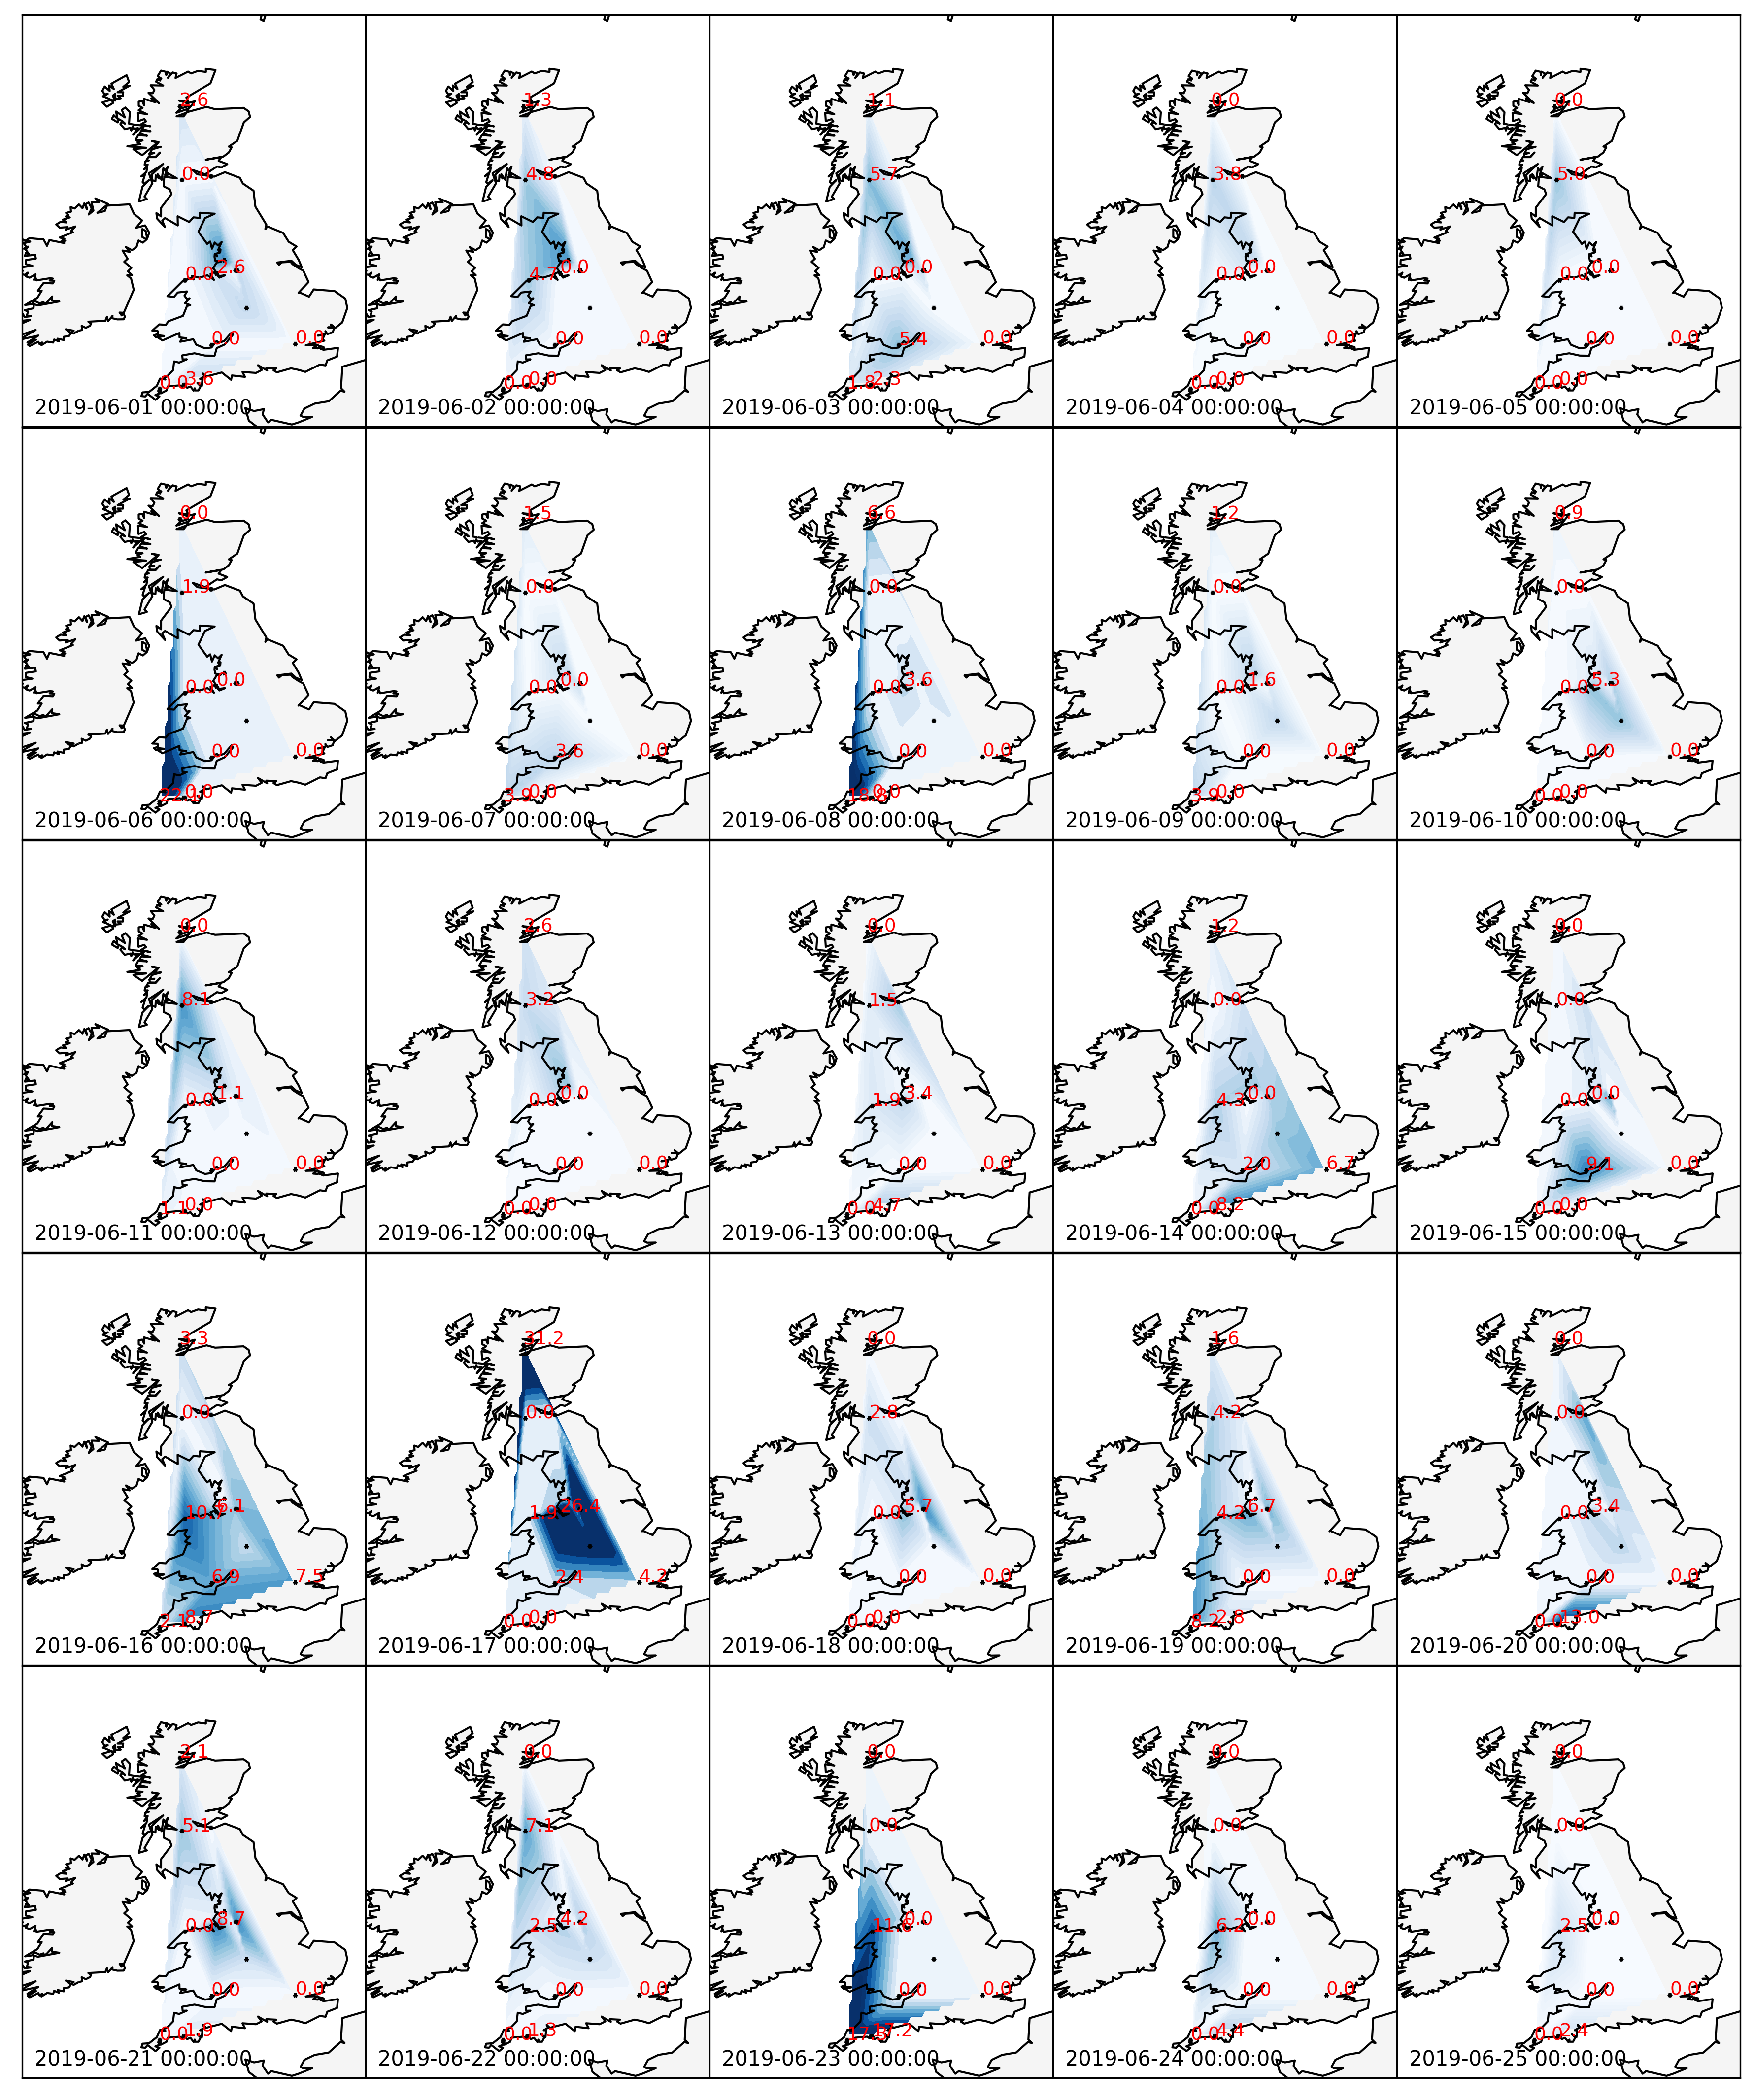

In [98]:
#plot true rain map
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig, axes = plt.subplots(nrows=5, ncols=5,sharex=True,sharey=True,figsize=(15,18.5))
for day,ax in tqdm(enumerate(axes.flat)):
    map_ax =Basemap(projection='mill',
            resolution='l',llcrnrlat = 49.205456,
            llcrnrlon = -10.055147,
            urcrnrlat = 60.002848,
            urcrnrlon = 2.431562,
            ax=ax)
    fig.set_dpi(300)
    map_ax.drawcoastlines()
    map_ax.fillcontinents('whitesmoke')
    ax.set_aspect('equal')
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    plt.subplots_adjust(wspace=0, hspace=0)
    im=ax.contourf(xi, yi, griddata((x11_lat, y11_lon),
     [gamma_allcities[k][5][day+1977] for l,k in enumerate(range(13))],
      (xi[None,:], yi[:,None]), method='linear'),13,vmin=0, vmax=13,cmap='Blues')
    for i in range(len(x11_lat)):
        ax.scatter(x11_lat[i],y11_lon[i],color='black',s=5,marker='2')
        ax.text(x11_lat[i],y11_lon[i],
        [round(gamma_allcities[i][5][day+1977],1) if k>0 else '' for k in [1,1,1,0,0,1,0,1,0,1,1,1,0]][i],color='red',size=9)
    ax.text(x=50000,y=50000,s=to_datetime(gamma_allcities[0][6][day+1977]))
    

plt.show()


### Heatmap for simulated rain

In [103]:
median_sim=[]
for idx,id in enumerate(range(13)):
    median_sim.append([ sorted(sim_rain11_1000[i][idx])[499] for i in range(25)])

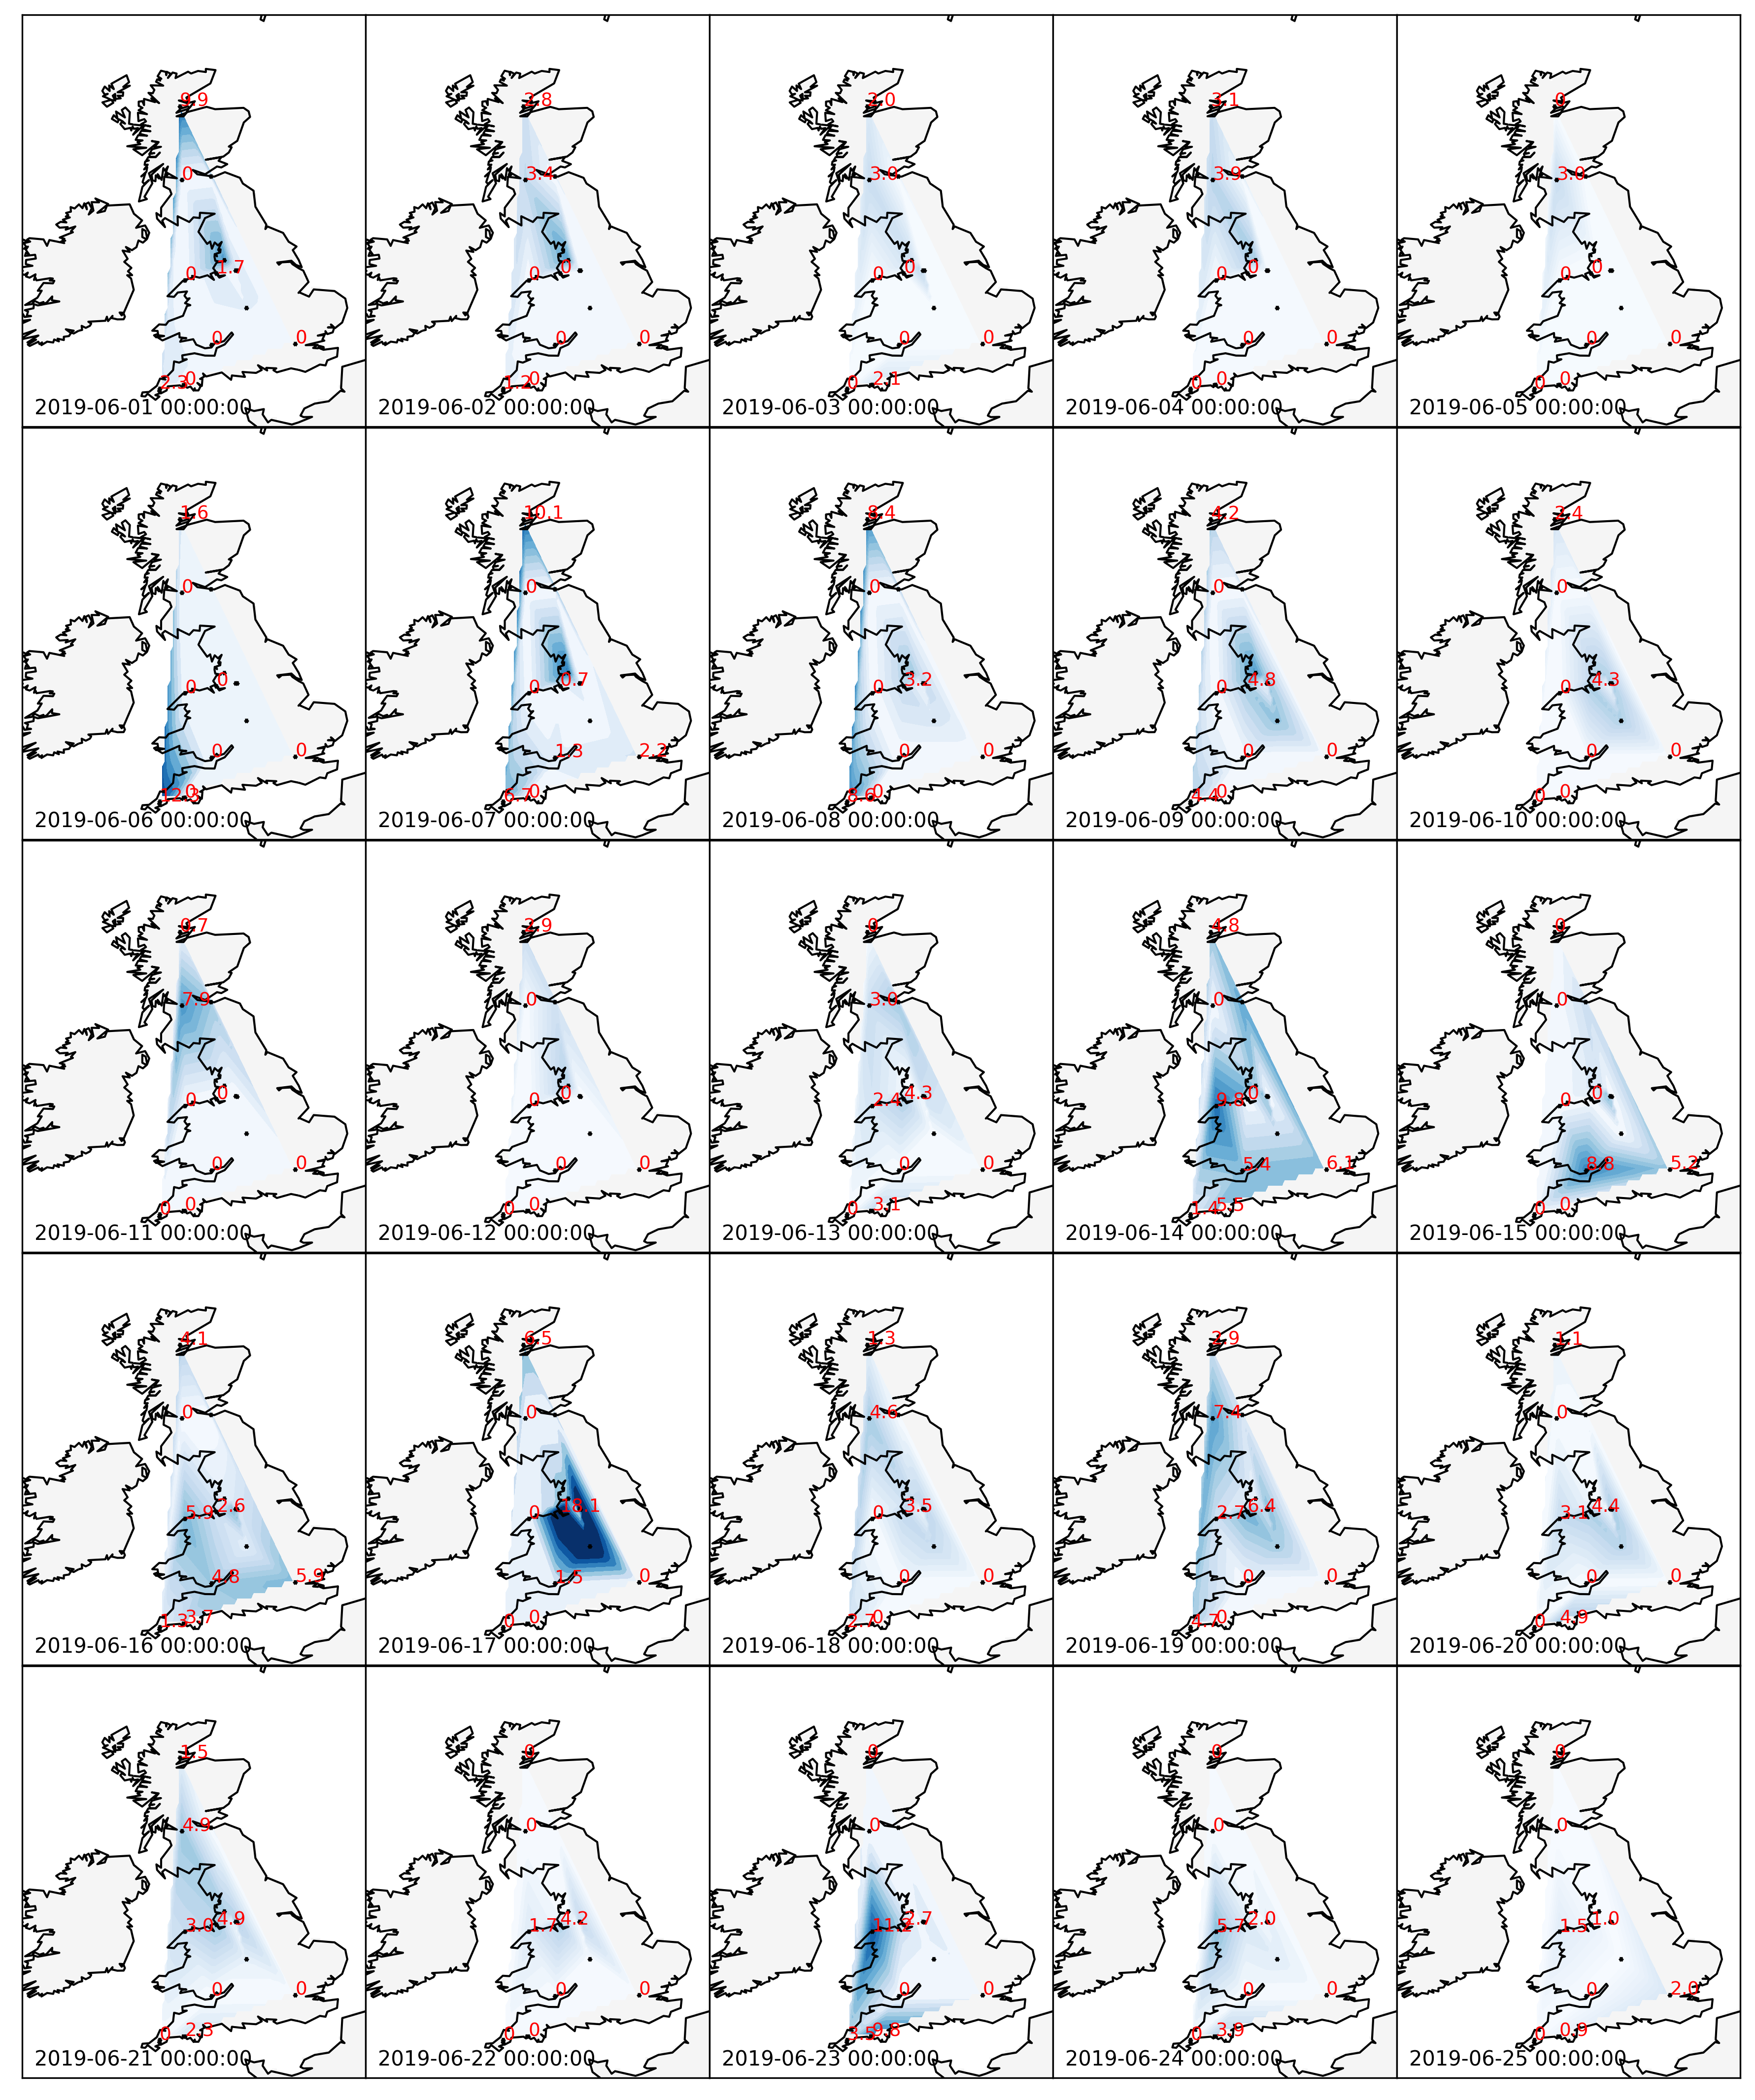

In [146]:
#plot simulated rain map
from mpl_toolkits.axes_grid1 import make_axes_locatable


fig, axes = plt.subplots(nrows=5, ncols=5,sharex=True,sharey=True,figsize=(15,18.5))
for day,ax in enumerate(axes.flat):
    map_ax =Basemap(projection='mill',
            resolution='l',llcrnrlat = 49.205456,
            llcrnrlon = -10.055147,
            urcrnrlat = 60.002848,
            urcrnrlon = 2.431562,
            ax=ax)
    fig.set_dpi(300)
    map_ax.drawcoastlines()
    map_ax.drawlsmask(land_color='whitesmoke')
    ax.set_aspect('equal')
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    plt.subplots_adjust(wspace=0, hspace=0)
    im=ax.contourf(xi, yi, griddata((x11_lat, y11_lon),
     [median_sim[l][day] for l,k in enumerate(range(13))],
      (xi[None,:], yi[:,None]), method='linear'),10,vmin=0, vmax=13,cmap='Blues')
    for i in range(len(x11_lat)):
        ax.scatter(x11_lat[i],y11_lon[i],color='black',s=5,marker='2')
        ax.text(x11_lat[i],y11_lon[i],
        [round(median_sim[i][day],1) if k>0 else '' for k in [1,1,1,0,0,1,0,1,0,1,1,1,0]][i],size=9,color='r')
    ax.text(x=50000,y=50000,s=to_datetime(gamma_allcities[0][6][day+1977]))

    


plt.show()


### Copula density plot

In [7]:
### marginalising for 2 locations : 1_0 Albury 4_2Ballarat with idall_id11
from tqdm import tqdm

cop_x=np.linspace(0.01,0.99,80)
cop_gridx2,cop_gridy2=np.meshgrid(cop_x,cop_x)

Z=np.zeros(cop_gridx2.shape)
for i in tqdm(range(Z.shape[0])):
    for j in range(Z.shape[1]):
        Z[i,j]=np.sum([-norm_cop_loconly(L=loc_dist_mat).nll([1.99955786e+13, 3.75838189e-03],[np.hstack(([cop_gridx2[i][j]],np.random.uniform(),[cop_gridy2[i][j]],np.random.uniform(size=10)))]) for t in range(20)])
    

100%|██████████| 80/80 [08:25<00:00,  6.32s/it]


In [144]:
cities[2]

'Glasgow'

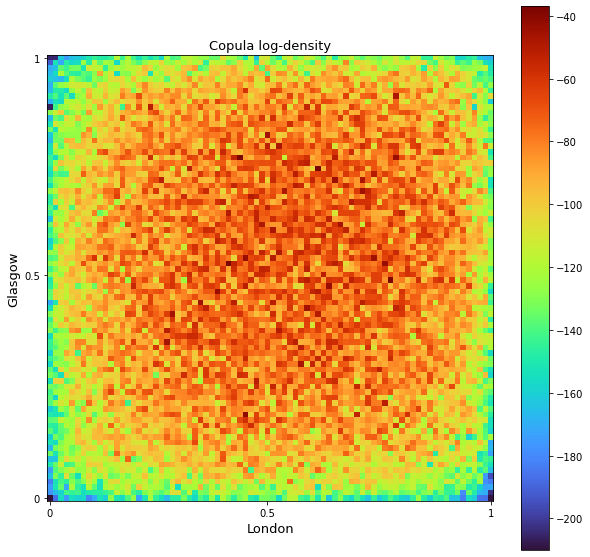

In [8]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,10)) 
plt.rcParams["axes.grid"] = False
dpi=5000
plt.xticks([0,39,79],[0,0.5,1],size=10)
plt.yticks([0,39,79],[1,0.5,0],size=10)
plt.imshow(np.flip(Z,0),cmap='turbo')
plt.xlabel('London',size=13)
plt.ylabel('Glasgow',size=13)
plt.title('Copula log-density',size=13)
plt.colorbar()
plt.show()

In [ ]:
# thesis
# 1first introduction and summary of previous work
# 2Mathematical framework without going into details, more math and skalrs and detail, can talk about previous work
# 3Neural hierarchical with detail and full explanation
# 4 Spatial Copula ``
# 5 Results for GNN /or a chapter after each of chapter 3 and 4
# 6 copula results
# 7 conclusion and discussion


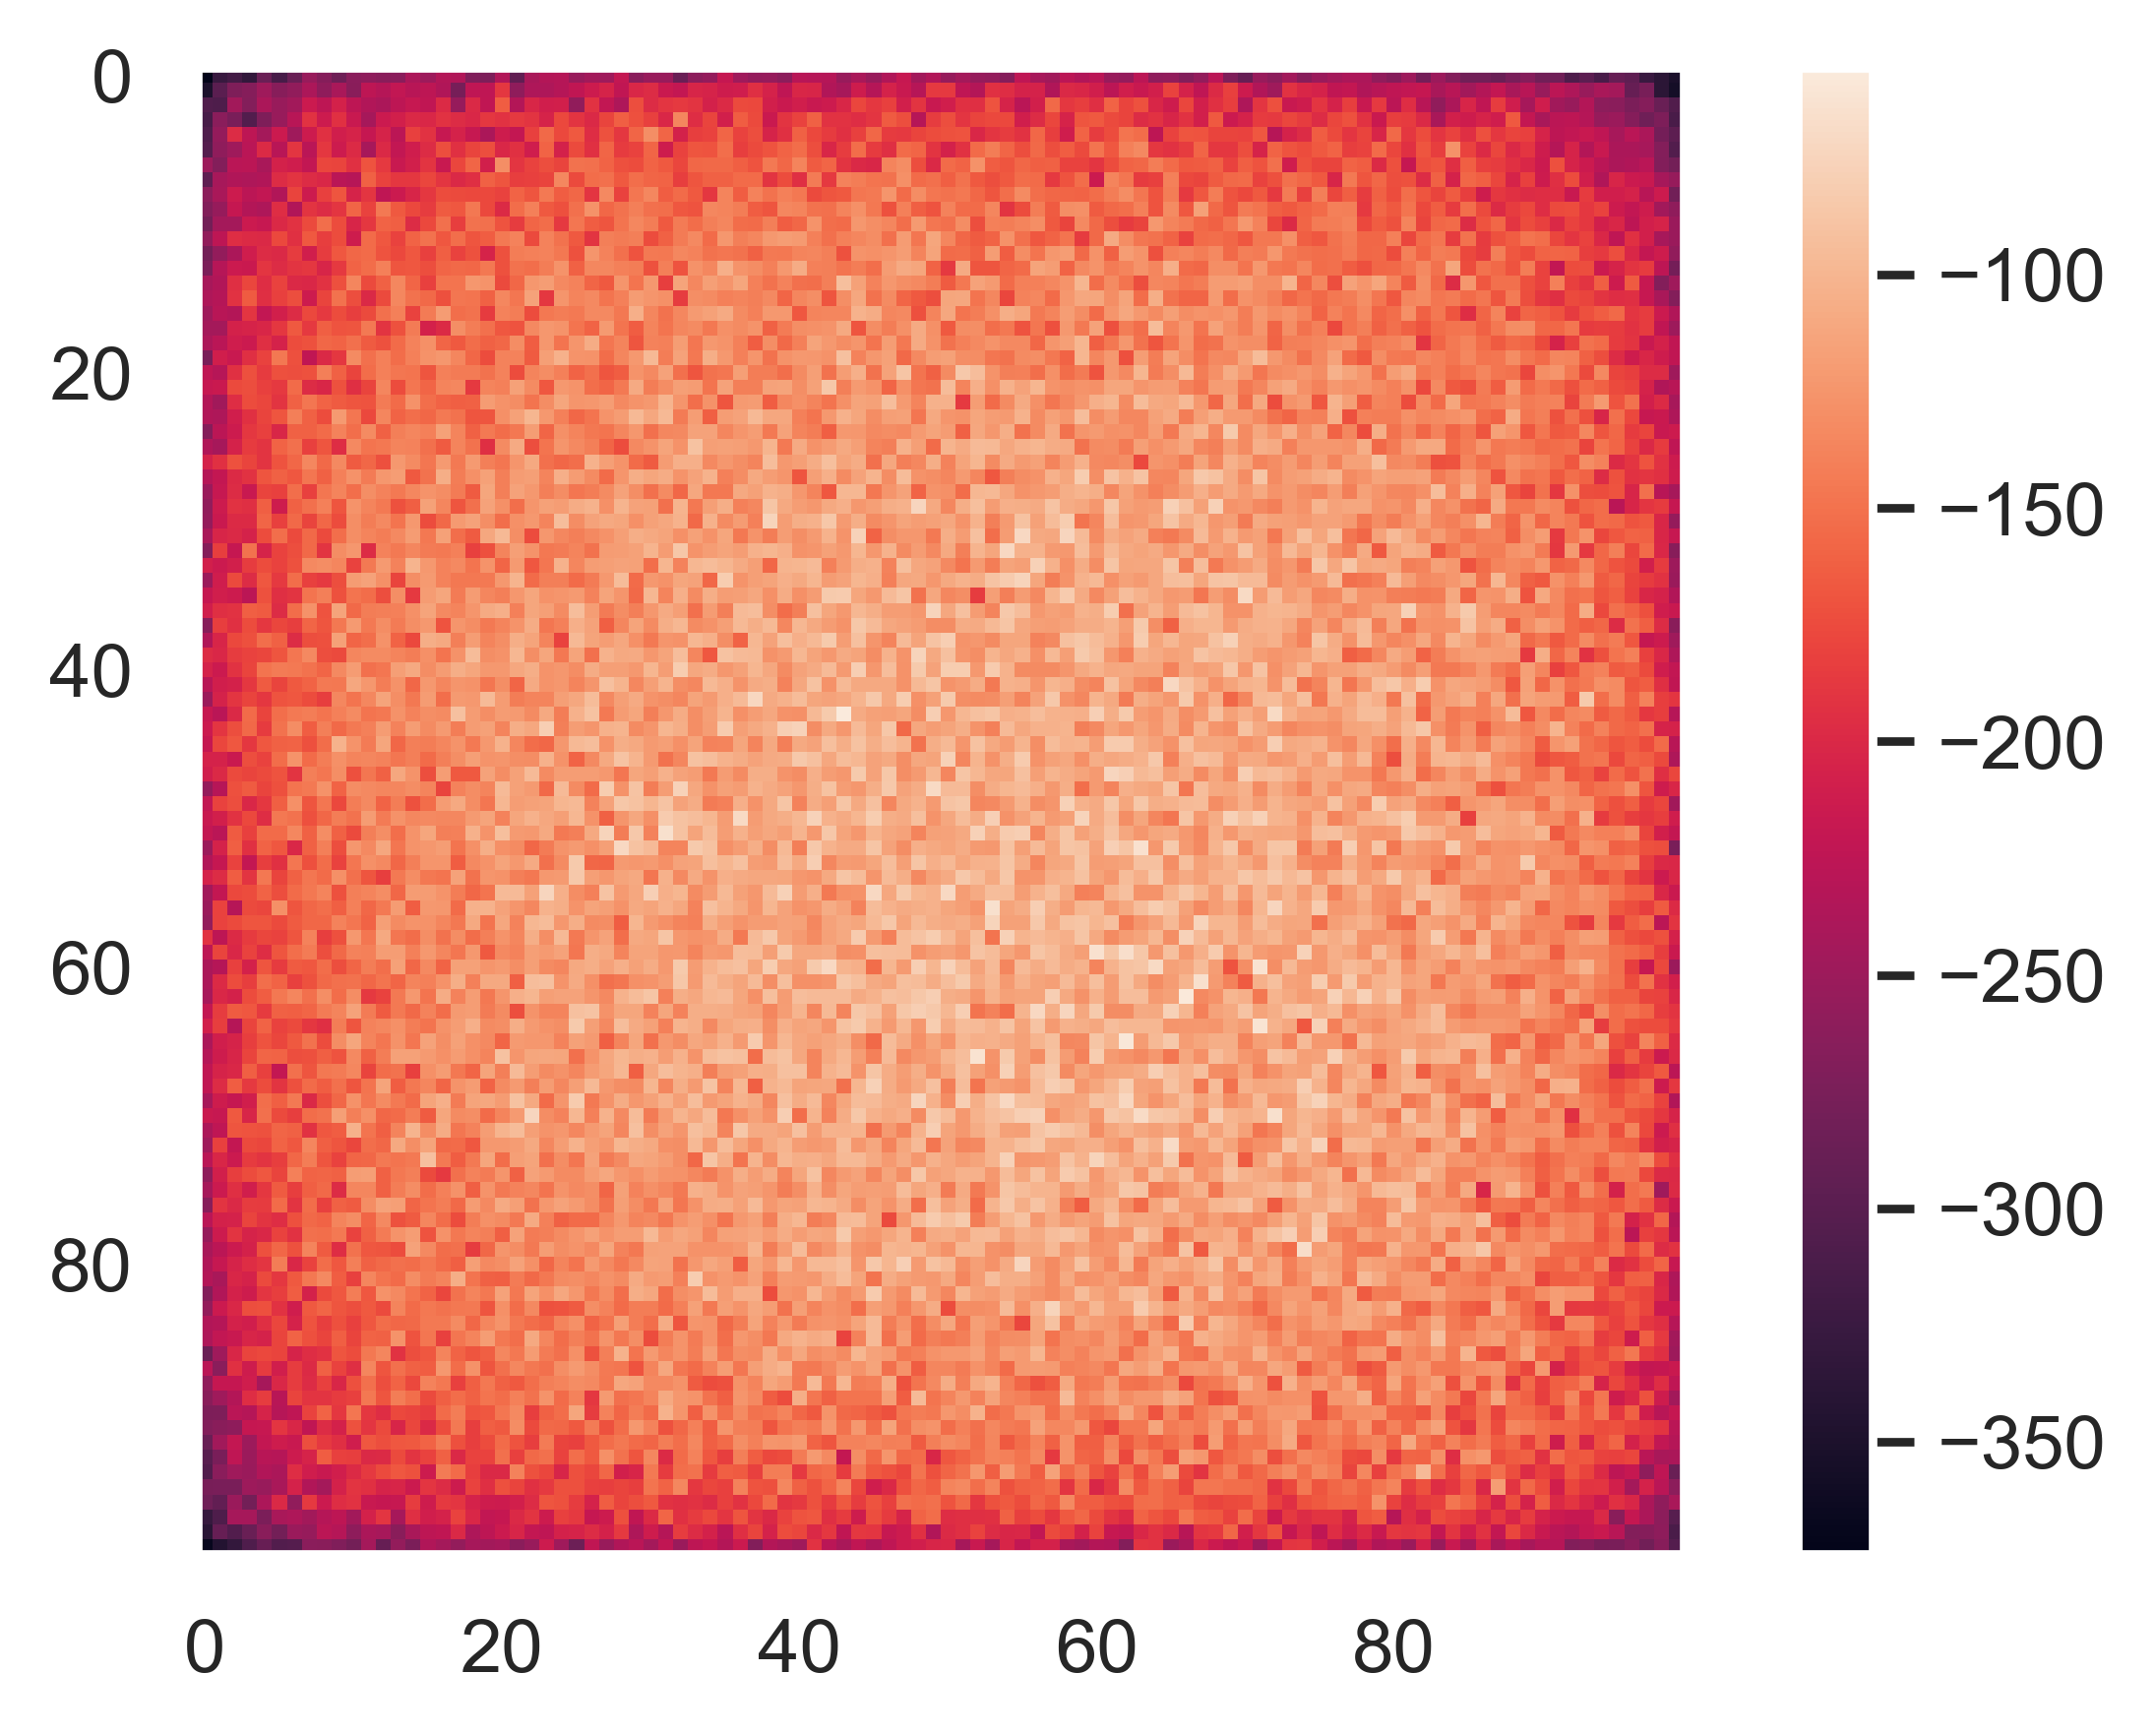

In [496]:
plt.imshow(Z)
plt.colorbar()